In [1]:
# Cell 1: Setup Environment and Configuration
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import QuantileTransformer # For loading the scaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import joblib # For loading sklearn scalers
import time
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="xgboost") # Suppress XGBoost UserWarning about feature names

# --- Configuration ---
# TODO: USER - Update these paths to point to your saved models, scaler, and new data
BASE_PATH = "" # Base directory for models and data
NEW_DATA_CSV = os.path.join(BASE_PATH, "traffic.csv") # Your new data file
TARGET_SCALER_PATH = os.path.join(BASE_PATH, "target_scaler.joblib")
TEMPORAL_SCALERS_PATH = os.path.join(BASE_PATH, "temporal_scalers.joblib")

PATCHTSMIXER_MODEL_DIR = os.path.join(BASE_PATH, "PatchTST_lag_only_model")
XGBOOST_REFINEMENT_MODEL_PATH = os.path.join(BASE_PATH, "final_xgboost_refinement_model.json")
NN_REFINEMENT_MODEL_PATH = os.path.join(BASE_PATH, "best_nn_refine_patchtst_model.pt")
DISTILLED_NN_MODEL_PATH = os.path.join(BASE_PATH, "best_distilled_nn_PatchTST_model_further_enhanced.pt")

OUTPUT_PREDICTIONS_CSV = os.path.join(BASE_PATH, "new_data_predictions_output.csv")

# Model Parameters (should match training)
CONTEXT_LENGTH = 168  # Number of past values used by PatchTSMixer
PREDICTION_LENGTH = 1   # Number of future values PatchTSMixer predicts (typically 1 for this setup)
TARGET_COLUMN = 'Vehicles' # Name of the target column in your new CSV (if it exists for evaluation)
DATETIME_COLUMN = 'DateTime' # Name of the datetime column in your new CSV
JUNCTION_TO_FILTER = 1 # Example: Set to None if no junction filtering is needed

# PyTorch Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()

# Define temporal features list (must match features used for training refinement models)
TEMPORAL_FEATURES_LIST = [
    'hour', 'day_of_week', 'day', 'month', 'year',
    'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
    'month_sin', 'month_cos', 'is_weekend', 'is_workday',
    'morning_rush', 'evening_rush', 'is_rush_hour'
]

# Define interaction features list (must match features used for training refinement models)
INTERACTION_FEATURES_LIST = [
    'patchtsmixer_x_hour_sin', 'patchtsmixer_x_hour_cos', 
    'patchtsmixer_x_is_weekend', 'patchtsmixer_x_is_rush'
]
# Base feature for refinement models is the PatchTSMixer prediction
BASE_REFINEMENT_FEATURE = 'patchtsmixer_pred'
ALL_REFINEMENT_FEATURES = [BASE_REFINEMENT_FEATURE] + TEMPORAL_FEATURES_LIST + INTERACTION_FEATURES_LIST

# For plotting
plt.style.use('seaborn-v0_8-whitegrid')

Using device: cuda
CUDA Device Name: NVIDIA GeForce GTX 1050 Ti


## Define Model Architectures and Helper Functions
This cell contains the definitions for the `RefinementNN` class (used by NN-Refinement and Distilled-NN models) and helper functions for datetime feature extraction and data preparation for the PatchTSMixer model. These should be identical to the ones used during training.

In [2]:
# Cell 2: Model/Helper Definitions

# --- RefinementNN Class (from original training) ---
class RefinementNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], output_dim=1, dropout_rate=0.4):
        super(RefinementNN, self).__init__()
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        current_dim = input_dim
        for h_dim in hidden_dims:
            self.layers.append(nn.Linear(current_dim, h_dim))
            self.batch_norms.append(nn.BatchNorm1d(h_dim))
            current_dim = h_dim
        self.output_layer = nn.Linear(current_dim, output_dim)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if x.size(0) > 1: # Apply BatchNorm only if batch size > 1
                 x = self.batch_norms[i](x)
            x = F.leaky_relu(x, negative_slope=0.01)
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

# --- Datetime Feature Extraction (from original training) ---
def extract_enhanced_datetime_features(df, datetime_col='DateTime'):
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df['hour'] = df[datetime_col].dt.hour
    df['day_of_week'] = df[datetime_col].dt.dayofweek
    df['day'] = df[datetime_col].dt.day
    df['month'] = df[datetime_col].dt.month
    df['year'] = df[datetime_col].dt.year
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['is_workday'] = (~df['is_weekend']).astype(int)
    df['morning_rush'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)
    df['evening_rush'] = ((df['hour'] >= 16) & (df['hour'] <= 19)).astype(int)
    df['is_rush_hour'] = ((df['morning_rush'] | df['evening_rush']) & df['is_workday']).astype(int)
    return df

# --- Data Preparation for PatchTSMixer (adapted for prediction) ---
def prepare_transformer_data_for_prediction(df, context_length, prediction_length, 
                                            target_col=None, datetime_col='DateTime'):
    """
    Prepares data sequences for PatchTSMixer prediction.
    Returns past_values, past_observed_mask, actual future values (if target_col provided),
    and the original DataFrame indices corresponding to the start of each prediction window.
    """
    values = df[target_col].values if target_col and target_col in df.columns else None
    
    past_values_list, past_observed_mask_list = [], []
    actual_future_values_list = [] # For evaluation if target_col is present
    prediction_start_indices = [] # Original df indices for DateTime alignment

    total_len_needed = context_length + prediction_length
    
    # If target_col is not present, we can't use it to create past_values.
    # PatchTSMixer typically uses the target variable itself as input for forecasting.
    # If new data doesn't have the target, this setup assumes PatchTSMixer was trained
    # on a univariate series (the target itself).
    # For this function to be general, we'll assume 'values_for_input' are the target series.
    # If target_col is None, this function cannot create past_values from it.
    # Let's assume for now that if target_col is None, we are in a scenario where
    # we only want to process up to the point where we have data, and PatchTSMixer
    # would be fed some other input.
    # However, the typical use case is that `values` *is* the series being predicted.
    
    # For prediction, we need at least `context_length` of data.
    # The `past_values` will be taken from the available data.
    # If `target_col` is present, we can also extract `actual_future_values`.

    # Let's assume `df` contains the series up to the point of prediction.
    # We will create sequences from `df[target_col]` if available, or assume
    # the user will provide appropriate `past_values` to the model.
    # This function will focus on creating sequences from `df[target_col]`.

    if not target_col or target_col not in df.columns:
        print(f"Warning: Target column '{target_col}' not found in DataFrame. Cannot create actual_future_values.")
        # If no target column, we can still create past_values if the model is univariate
        # and was trained on some other column that IS present, or if we are just demonstrating
        # the sequence creation. For this pipeline, we expect target_col to be the series.
        # If it's missing, we can't proceed with this specific way of forming past_values.
        # For now, let's assume `df` itself is the series if `target_col` is not given.
        # This part needs careful consideration based on how PatchTSMixer is used.
        # For this pipeline, we'll assume `target_col` is essential for creating `past_values`.
        if not target_col:
             raise ValueError("target_col must be specified to create past_values for PatchTSMixer.")
        
    # Use the target column for creating past_values
    series_to_sequence = df[target_col].values

    for i in range(len(series_to_sequence) - total_len_needed + 1):
        past_values_list.append(series_to_sequence[i : i + context_length])
        past_observed_mask_list.append(np.ones(context_length, dtype=bool))
        prediction_start_indices.append(df.index[i + context_length]) # Index in original df

        if values is not None: # If target_col was present and valid
            actual_future_values_list.append(values[i + context_length : i + total_len_needed])

    past_values_np = np.array(past_values_list)
    past_mask_np = np.array(past_observed_mask_list)
    
    actual_future_values_np = np.array(actual_future_values_list) if actual_future_values_list else None
    
    # Get the corresponding DateTime values for each prediction start
    # These are the timestamps for which predictions are made (t+1, t+2, ..., t+prediction_length)
    # For refinement models (predicting t+1), we'll use the first of these.
    prediction_datetimes = df.loc[prediction_start_indices, datetime_col].values
    
    # Also get temporal features corresponding to each prediction start index
    # These features are for the time step t+context_length (i.e., the first prediction step)
    aligned_temporal_features = df.loc[prediction_start_indices, TEMPORAL_FEATURES_LIST].values
    
    return (
        past_values_np,
        past_mask_np,
        actual_future_values_np, # Actual values for evaluation (can be None)
        prediction_datetimes,    # DateTime for each prediction made
        aligned_temporal_features # Temporal features aligned with each prediction
    )

print("Helper functions and RefinementNN class defined.")

Helper functions and RefinementNN class defined.


## Load and Preprocess New Input Data
Load the new CSV data. Filter for a specific junction if applicable (e.g., if models were trained on data from a single junction). Sort the data by DateTime and extract enhanced datetime features.

In [3]:
# Cell 3: Load new CSV, filter, sort, feature engineering

print(f"Loading new data from: {NEW_DATA_CSV}")
if not os.path.exists(NEW_DATA_CSV):
    raise FileNotFoundError(f"New data CSV file not found at {NEW_DATA_CSV}. Please provide the correct path.")

df_full_initial = pd.read_csv(NEW_DATA_CSV)
print(f"Original full data shape: {df_full_initial.shape}")

# Ensure DateTime column is parsed
df_full_initial[DATETIME_COLUMN] = pd.to_datetime(df_full_initial[DATETIME_COLUMN])

# Filter by junction if specified
df_junction_data = df_full_initial.copy() # Start with a copy
if JUNCTION_TO_FILTER is not None and 'Junction' in df_junction_data.columns:
    print(f"Filtering for Junction {JUNCTION_TO_FILTER}")
    df_junction_data = df_junction_data[df_junction_data['Junction'] == JUNCTION_TO_FILTER].copy()
    if df_junction_data.empty:
        raise ValueError(f"No data found for Junction {JUNCTION_TO_FILTER} in the dataset.")
    print(f"Data shape after Junction {JUNCTION_TO_FILTER} filter: {df_junction_data.shape}")
elif 'Junction' not in df_junction_data.columns and JUNCTION_TO_FILTER is not None:
    print(f"Warning: Junction column not found, but JUNCTION_TO_FILTER ({JUNCTION_TO_FILTER}) is set. Proceeding with all data.")
else:
    print("No junction filtering applied or 'Junction' column not present.")

# Sort data by DateTime (essential for time series)
df_junction_data_sorted = df_junction_data.sort_values(DATETIME_COLUMN).reset_index(drop=True)

# Determine the test set (last 20% of the filtered and sorted data)
test_set_percentage = 0.20
num_total_rows = len(df_junction_data_sorted)
num_test_rows = int(num_total_rows * test_set_percentage)

if num_test_rows == 0 and num_total_rows > 0: # Ensure at least 1 row for test if data is very small
    num_test_rows = 1
    print(f"Warning: 20% of data is 0 rows. Setting test set to 1 row.")


# We need CONTEXT_LENGTH history before the actual test set starts
# The data passed to feature engineering and then to PatchTSMixer preparation
# should include this context plus the test set itself.
required_data_length_for_test_and_context = CONTEXT_LENGTH + num_test_rows

if num_total_rows < required_data_length_for_test_and_context:
    raise ValueError(
        f"Insufficient data for Junction {JUNCTION_TO_FILTER}. "
        f"Need {required_data_length_for_test_and_context} rows (CONTEXT_LENGTH {CONTEXT_LENGTH} + last 20% test data {num_test_rows}), "
        f"but only found {num_total_rows} total rows after filtering and sorting."
    )

# Select the slice of data: CONTEXT_LENGTH history + last 20% test data
# The end of this slice is the end of the junction data.
# The start of this slice is `num_test_rows + CONTEXT_LENGTH` rows from the end.
start_index_for_new_df = num_total_rows - (num_test_rows + CONTEXT_LENGTH)
df_new_raw_for_prediction = df_junction_data_sorted.iloc[start_index_for_new_df:].copy()

print(f"Selected last {num_test_rows} data points for testing (20% of Junction {JUNCTION_TO_FILTER} data).")
print(f"Including {CONTEXT_LENGTH} preceding data points for context.")
print(f"Shape of data being processed for prediction (context + test): {df_new_raw_for_prediction.shape}")

# This df_new_sorted will now be of length CONTEXT_LENGTH + num_test_rows
df_new_sorted = df_new_raw_for_prediction.reset_index(drop=True)


# Extract enhanced datetime features
df_new_sorted = extract_enhanced_datetime_features(df_new_sorted, datetime_col=DATETIME_COLUMN)
print("Enhanced datetime features extracted for the selected data slice.")
print(f"Columns after feature extraction: {df_new_sorted.columns.tolist()}")

# Check if target column exists in the new data (for potential evaluation)
has_target_column = TARGET_COLUMN in df_new_sorted.columns
if has_target_column:
    print(f"Target column '{TARGET_COLUMN}' found in the data slice. Evaluation will be possible.")
    # Check for NaNs in target column within this slice
    if df_new_sorted[TARGET_COLUMN].isnull().any():
        print(f"Warning: Target column '{TARGET_COLUMN}' in the selected slice contains NaN values. Attempting to drop rows with NaN target.")
        df_new_sorted.dropna(subset=[TARGET_COLUMN], inplace=True)
        df_new_sorted = df_new_sorted.reset_index(drop=True) # Reset index after drop
        print(f"Shape after dropping NaN targets from slice: {df_new_sorted.shape}")
        if df_new_sorted.empty:
            raise ValueError("All rows dropped from slice after removing NaN targets. Cannot proceed.")
        # After dropping NaNs, re-check if we still have enough data
        if len(df_new_sorted) < CONTEXT_LENGTH + PREDICTION_LENGTH : # PREDICTION_LENGTH is usually 1 here
             raise ValueError(
                f"After dropping NaNs from target in the slice, data length ({len(df_new_sorted)}) is less than "
                f"CONTEXT_LENGTH ({CONTEXT_LENGTH}) + PREDICTION_LENGTH ({PREDICTION_LENGTH}). Cannot create sequences."
            )
else:
    print(f"Warning: Target column '{TARGET_COLUMN}' not found in the data slice. Evaluation against actuals will not be possible.")
    # This pipeline expects TARGET_COLUMN for past_values. prepare_transformer_data_for_prediction will handle error if needed.

# Verify sufficient data length for sequence creation (already partially checked if NaNs were dropped)
# The `prepare_transformer_data_for_prediction` function will take df_new_sorted (length: CONTEXT_LENGTH + num_test_rows)
# and generate `num_test_rows` predictions.
if len(df_new_sorted) < CONTEXT_LENGTH + PREDICTION_LENGTH: # PREDICTION_LENGTH is 1
    raise ValueError(
        f"Final data slice length ({len(df_new_sorted)}) is less than CONTEXT_LENGTH ({CONTEXT_LENGTH}) + "
        f"PREDICTION_LENGTH ({PREDICTION_LENGTH}). Cannot create sequences. This might occur if too many NaNs were dropped."
    )

print("\nNew data preprocessing complete for the defined test set (last 20% with context).")
df_new_sorted.info()

Loading new data from: traffic.csv
Original full data shape: (48120, 4)
Filtering for Junction 1
Data shape after Junction 1 filter: (14592, 4)
Selected last 2918 data points for testing (20% of Junction 1 data).
Including 168 preceding data points for context.
Shape of data being processed for prediction (context + test): (3086, 4)
Enhanced datetime features extracted for the selected data slice.
Columns after feature extraction: ['DateTime', 'Junction', 'Vehicles', 'ID', 'hour', 'day_of_week', 'day', 'month', 'year', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'is_weekend', 'is_workday', 'morning_rush', 'evening_rush', 'is_rush_hour']
Target column 'Vehicles' found in the data slice. Evaluation will be possible.

New data preprocessing complete for the defined test set (last 20% with context).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3086 entries, 0 to 3085
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtyp

## Load Target Scaler
Load the `QuantileTransformer` that was fitted on the target variable of the original training dataset. This is crucial for scaling the new data's target (if available for creating PatchTSMixer inputs or for evaluation) and for inverse-transforming the model predictions back to the original scale.

In [4]:
# Cell 4: Load target scaler
print(f"Attempting to load target scaler from: {TARGET_SCALER_PATH}")
target_scaler = None # Initialize
temporal_scaler = None # Initialize

try:
    if not os.path.exists(TARGET_SCALER_PATH):
        # This custom exception will be caught by the FileNotFoundError block below
        raise FileNotFoundError(f"Target scaler file not found at {TARGET_SCALER_PATH}.")
    target_scaler = joblib.load(TARGET_SCALER_PATH)
    print("Target scaler loaded successfully from file.")
except FileNotFoundError:
    print(f"Warning: Target scaler file not found at {TARGET_SCALER_PATH}.")
    print(f"Attempting to create and save a new scaler based on the target column '{TARGET_COLUMN}' from the loaded new data.")
    print("CAUTION: This is NOT recommended if a scaler from the original training data exists or can be created. "
          "Using a scaler fitted on new/different data can lead to suboptimal model performance "
          "or misinterpretation of results. Ensure this data is representative if proceeding.")

    if 'df_new_sorted' not in globals() or df_new_sorted.empty:
        raise RuntimeError("DataFrame 'df_new_sorted' not found or is empty. "
                           "Please ensure Cell 3 (Load and Preprocess New Input Data) has been run successfully before this cell.")
    
    if TARGET_COLUMN not in df_new_sorted.columns:
        raise ValueError(f"Target column '{TARGET_COLUMN}' not found in the preprocessed data ('df_new_sorted'). "
                         "Cannot create scaler.")

    print(f"Using '{TARGET_COLUMN}' from 'df_new_sorted' (shape: {df_new_sorted.shape}) to fit a new QuantileTransformer.")
    
    # df_new_sorted in Cell 3 should have handled NaNs in TARGET_COLUMN by dropping rows.
    target_values_for_fitting = df_new_sorted[TARGET_COLUMN].values.reshape(-1, 1)

    if len(target_values_for_fitting) == 0:
         raise ValueError("Error: No data available in the target column of 'df_new_sorted' for scaler fitting. "
                          "This might happen if all rows had NaN targets and were dropped in Cell 3.")

    print(f"Fitting QuantileTransformer to '{TARGET_COLUMN}' (using {len(target_values_for_fitting)} values)...")
    try:
        # Initialize QuantileTransformer
        target_scaler_instance = QuantileTransformer(output_distribution='normal', random_state=42, n_quantiles=min(1000, len(target_values_for_fitting)))
        target_scaler_instance.fit(target_values_for_fitting)
        target_scaler = target_scaler_instance # Assign to the main variable
        print("New QuantileTransformer fitted successfully.")
    except Exception as e:
        print(f"Error fitting new target scaler: {e}")
        raise

    print(f"Saving newly created target scaler to: {TARGET_SCALER_PATH}")
    try:
        os.makedirs(os.path.dirname(TARGET_SCALER_PATH), exist_ok=True) # Ensure directory exists
        joblib.dump(target_scaler, TARGET_SCALER_PATH)
        print(f"New target scaler saved successfully to {TARGET_SCALER_PATH}")
    except Exception as e:
        print(f"Error saving new target scaler: {e}")
        # Not raising here to allow script to continue if main target_scaler logic failed but user wants to proceed with other parts
        
except Exception as e:
    print(f"An unexpected error occurred while loading or creating the target scaler: {e}")
    # Potentially raise, or allow to continue if target_scaler is not critical for all paths
    # For this script, target_scaler is critical for inverse transform.
    raise

# --- Load Temporal Scaler ---
print(f"\nAttempting to load temporal scaler from: {TEMPORAL_SCALERS_PATH}")
try:
    if not os.path.exists(TEMPORAL_SCALERS_PATH):
        raise FileNotFoundError(f"Temporal scalers file not found at {TEMPORAL_SCALERS_PATH}.")
    temporal_scaler = joblib.load(TEMPORAL_SCALERS_PATH)
    print("Temporal scalers loaded successfully from file.")
except FileNotFoundError:
    print(f"Warning: Temporal scalers file not found at {TEMPORAL_SCALERS_PATH}.")
    print("Temporal features will be used unscaled for refinement models. This may impact performance if models were trained with scaled temporal features.")
    temporal_scaler = None # Explicitly set to None
except Exception as e:
    print(f"An unexpected error occurred while loading the temporal scalers: {e}")
    print("Temporal features will be used unscaled due to this error.")
    temporal_scaler = None # Explicitly set to None

if target_scaler is None:
    print("\nCRITICAL WARNING: Target scaler is None. Inverse transformation of predictions will fail. "
          "Ensure TARGET_SCALER_PATH is correct or that the fallback fitting logic (if used) was successful.")

Attempting to load target scaler from: target_scaler.joblib
Target scaler loaded successfully from file.

Attempting to load temporal scaler from: temporal_scalers.joblib
Temporal scalers loaded successfully from file.


## Prepare Data for PatchTSMixer
If the target column is present in the new data, scale it using the loaded `target_scaler`. Then, use the `prepare_transformer_data_for_prediction` function to create input sequences (`past_values`, `past_observed_mask`) for the PatchTSMixer model. This function will also return actual future values (if available) and aligned DateTime stamps and temporal features for later use with refinement models and output generation.

In [5]:
# Cell 5: Scale target (if present) and prepare inputs for PatchTSMixer

# Create a copy of the sorted DataFrame for scaling, to keep original values if needed
df_for_scaling = df_new_sorted.copy()

if has_target_column:
    print(f"Scaling the target column '{TARGET_COLUMN}' in the new data.")
    # The scaler expects a 2D array, so reshape, transform, and flatten.
    df_for_scaling[TARGET_COLUMN] = target_scaler.transform(df_for_scaling[TARGET_COLUMN].values.reshape(-1, 1)).flatten()
    print(f"Target column '{TARGET_COLUMN}' scaled.")
else:
    # If target column is not present, we cannot scale it.
    # The `prepare_transformer_data_for_prediction` function will raise an error
    # if TARGET_COLUMN is required for `past_values` and is missing.
    # This pipeline assumes TARGET_COLUMN is the series PatchTSMixer operates on.
    print(f"Target column '{TARGET_COLUMN}' not found. Cannot scale it. "
          f"Ensure PatchTSMixer inputs can be formed without it or provide the column.")


# Prepare data for PatchTSMixer using the (potentially scaled) target column
# The `prepare_transformer_data_for_prediction` function expects TARGET_COLUMN to exist in df_for_scaling
# if it's to be used for creating past_values.
try:
    (
        new_past_values_np,         # Inputs for PatchTSMixer
        new_past_mask_np,           # Masks for PatchTSMixer
        new_actual_future_values_np,# Actual future values (scaled, if target was present)
        new_prediction_datetimes,   # DateTime for each prediction
        new_aligned_temporal_features # Temporal features for refinement models
    ) = prepare_transformer_data_for_prediction(
        df_for_scaling,
        context_length=CONTEXT_LENGTH,
        prediction_length=PREDICTION_LENGTH,
        target_col=TARGET_COLUMN if has_target_column else None, # Pass target_col only if it exists
        datetime_col=DATETIME_COLUMN
    )
except ValueError as e:
    if "target_col must be specified" in str(e) and not has_target_column:
        raise ValueError(
            f"Target column '{TARGET_COLUMN}' is missing from the new data, but it's required by "
            f"`prepare_transformer_data_for_prediction` to create `past_values` for PatchTSMixer. "
            f"Please ensure the column exists or modify the data preparation logic if PatchTSMixer "
            f"is intended to use a different input series."
        ) from e
    else:
        raise e


print(f"Shape of new_past_values_np: {new_past_values_np.shape}")
print(f"Shape of new_past_mask_np: {new_past_mask_np.shape}")
print(f"Shape of new_prediction_datetimes: {new_prediction_datetimes.shape}")
print(f"Shape of new_aligned_temporal_features: {new_aligned_temporal_features.shape}")

if new_actual_future_values_np is not None:
    print(f"Shape of new_actual_future_values_np (scaled): {new_actual_future_values_np.shape}")
    # These are the ground truth values (scaled) corresponding to the predictions we will make.
    # For single-step prediction (PREDICTION_LENGTH=1), this will be a 1D array after squeeze.
    if PREDICTION_LENGTH == 1 and new_actual_future_values_np.ndim > 1:
        y_actual_scaled_aligned = new_actual_future_values_np.squeeze()
    else:
        y_actual_scaled_aligned = new_actual_future_values_np
else:
    y_actual_scaled_aligned = None
    print("No actual future values extracted as target column was not available or not processed for this.")

# Convert to PyTorch tensors
new_past_values_tensor = torch.tensor(new_past_values_np, dtype=torch.float32).unsqueeze(-1).to(device) # Add channel dim
new_past_mask_tensor = torch.tensor(new_past_mask_np, dtype=torch.bool).unsqueeze(-1).to(device) # Add channel dim for mask

print(f"Shape of new_past_values_tensor: {new_past_values_tensor.shape}")
print(f"Shape of new_past_mask_tensor: {new_past_mask_tensor.shape}")
print("Data prepared for PatchTSMixer input.")

Scaling the target column 'Vehicles' in the new data.
Target column 'Vehicles' scaled.
Shape of new_past_values_np: (2918, 168)
Shape of new_past_mask_np: (2918, 168)
Shape of new_prediction_datetimes: (2918,)
Shape of new_aligned_temporal_features: (2918, 16)
Shape of new_actual_future_values_np (scaled): (2918, 1)
Shape of new_past_values_tensor: torch.Size([2918, 168, 1])
Shape of new_past_mask_tensor: torch.Size([2918, 168, 1])
Data prepared for PatchTSMixer input.


## Load Pre-trained Models
Load all pre-trained models: PatchTSMixer, XGBoost refinement model, NN-Refinement model, and Distilled-NN model. Ensure all models are set to evaluation mode (`.eval()`).

In [6]:
# Cell 6: Load Pre-trained Models
from transformers import PatchTSTForPrediction # PatchTSTConfig might be implicitly handled

# --- Load PatchTST Model ---
print(f"Loading PatchTST model from: {PATCHTSMIXER_MODEL_DIR}")
if not os.path.isdir(PATCHTSMIXER_MODEL_DIR): # from_pretrained expects a directory
    raise FileNotFoundError(f"PatchTST model directory not found at {PATCHTSMIXER_MODEL_DIR}")
patchtst_model = PatchTSTForPrediction.from_pretrained(PATCHTSMIXER_MODEL_DIR).to(device)
patchtst_model.eval()
print("PatchTST model loaded and set to eval mode.")

# --- Load XGBoost Refinement Model ---
print(f"Loading XGBoost refinement model from: {XGBOOST_REFINEMENT_MODEL_PATH}")
if not os.path.exists(XGBOOST_REFINEMENT_MODEL_PATH):
    warnings.warn(f"XGBoost refinement model file not found at {XGBOOST_REFINEMENT_MODEL_PATH}. XGBoost predictions will be skipped.")
    xgb_refine_model = None
else:
    xgb_refine_model = xgb.Booster()
    xgb_refine_model.load_model(XGBOOST_REFINEMENT_MODEL_PATH)
    print("XGBoost refinement model loaded.")

# --- Load NN-Refinement Model ---
print(f"Loading NN-Refinement model from: {NN_REFINEMENT_MODEL_PATH}")
if not os.path.exists(NN_REFINEMENT_MODEL_PATH):
    warnings.warn(f"NN-Refinement model file not found at {NN_REFINEMENT_MODEL_PATH}. NN-Refinement predictions will be skipped.")
    nn_refine_model = None
else:
    nn_input_dim = len(ALL_REFINEMENT_FEATURES)
    nn_refine_model = RefinementNN(input_dim=nn_input_dim).to(device)
    nn_refine_model.load_state_dict(torch.load(NN_REFINEMENT_MODEL_PATH, map_location=device))
    nn_refine_model.eval()
    print("NN-Refinement model loaded and set to eval mode.")

# --- Load Distilled-NN Model ---
print(f"Loading Distilled-NN model from: {DISTILLED_NN_MODEL_PATH}")
if not os.path.exists(DISTILLED_NN_MODEL_PATH):
    warnings.warn(f"Distilled-NN model file not found at {DISTILLED_NN_MODEL_PATH}. Distilled-NN predictions will be skipped.")
    distilled_nn_model = None
else:
    distilled_nn_input_dim = len(ALL_REFINEMENT_FEATURES)
    distilled_nn_model = RefinementNN(
        input_dim=distilled_nn_input_dim,
        hidden_dims=[512, 256, 128, 64, 32],
        dropout_rate=0.2
    ).to(device)
    distilled_nn_model.load_state_dict(torch.load(DISTILLED_NN_MODEL_PATH, map_location=device))
    distilled_nn_model.eval()
    print("Distilled-NN model loaded and set to eval mode.")

print("\nAll available models loaded.")


Loading PatchTST model from: PatchTST_lag_only_model
PatchTST model loaded and set to eval mode.
Loading XGBoost refinement model from: final_xgboost_refinement_model.json
Loading NN-Refinement model from: best_nn_refine_patchtst_model.pt
NN-Refinement model loaded and set to eval mode.
Loading Distilled-NN model from: best_distilled_nn_PatchTST_model_further_enhanced.pt
Distilled-NN model loaded and set to eval mode.

All available models loaded.


C:\Users\PLN\AppData\Local\Temp\ipykernel_21796\1685775635.py:15: UserWarning: XGBoost refinement model file not found at final_xgboost_refinement_model.json. XGBoost predictions will be skipped.
  warnings.warn(f"XGBoost refinement model file not found at {XGBOOST_REFINEMENT_MODEL_PATH}. XGBoost predictions will be skipped.")
C:\Users\PLN\AppData\Local\Temp\ipykernel_21796\1685775635.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlis

## Generate Predictions with All Models

### 1. PatchTSMixer Predictions
Generate predictions using the pre-trained PatchTSMixer model. These predictions will be on the scaled data.

In [7]:
# Cell 7: PatchTST predictions

print("Generating predictions with PatchTST...")
patchtst_preds_scaled_list = []

prediction_batch_size = 256 
num_batches = (len(new_past_values_tensor) + prediction_batch_size - 1) // prediction_batch_size

with torch.no_grad():
    for i in range(num_batches):
        start_idx = i * prediction_batch_size
        end_idx = min((i + 1) * prediction_batch_size, len(new_past_values_tensor))
        
        batch_past_values = new_past_values_tensor[start_idx:end_idx]
        batch_past_mask = new_past_mask_tensor[start_idx:end_idx]

        outputs = patchtst_model(
            past_values=batch_past_values,
            past_observed_mask=batch_past_mask
        )
        preds_scaled = outputs.prediction_outputs.squeeze().cpu().numpy()
        patchtst_preds_scaled_list.append(preds_scaled)

patchtst_preds_scaled = np.concatenate(patchtst_preds_scaled_list)

if patchtst_preds_scaled.ndim > 1 and patchtst_preds_scaled.shape[-1] == 1 and PREDICTION_LENGTH == 1:
     patchtst_preds_scaled = patchtst_preds_scaled.flatten()
elif patchtst_preds_scaled.ndim == 0:
     patchtst_preds_scaled = np.array([patchtst_preds_scaled.item()])

print(f"PatchTST scaled predictions generated. Shape: {patchtst_preds_scaled.shape}")

Generating predictions with PatchTST...
PatchTST scaled predictions generated. Shape: (2918,)


### 2. Prepare Features for Refinement Models
Combine the scaled predictions from PatchTSMixer with the aligned temporal features. Create interaction features if the refinement models were trained with them.

In [8]:
# Cell 8: Prepare features for refinement models

# Use patchtst_preds_scaled instead of patchtsmixer_preds_scaled
if len(patchtst_preds_scaled) != len(new_aligned_temporal_features):
    raise ValueError(
        f"Mismatch in length between PatchTST predictions ({len(patchtst_preds_scaled)}) "
        f"and aligned temporal features ({len(new_aligned_temporal_features)}). Cannot proceed with refinement."
    )

processed_temporal_features = new_aligned_temporal_features
if temporal_scaler is not None:
    print("Scaling aligned temporal features using loaded temporal_scaler.")
    try:
        processed_temporal_features = temporal_scaler.transform(new_aligned_temporal_features)
        print("Temporal features scaled successfully.")
    except Exception as e:
        print(f"Error scaling temporal features: {e}. Using unscaled temporal features instead.")
        processed_temporal_features = new_aligned_temporal_features
else:
    print("Warning: Temporal scaler not loaded or failed to load. Using unscaled temporal features for refinement models.")

refinement_features_df = pd.DataFrame(processed_temporal_features, columns=TEMPORAL_FEATURES_LIST)
refinement_features_df[BASE_REFINEMENT_FEATURE] = patchtst_preds_scaled

refinement_features_df['patchtsmixer_x_hour_sin'] = refinement_features_df[BASE_REFINEMENT_FEATURE] * refinement_features_df.get('hour_sin', 0)
refinement_features_df['patchtsmixer_x_hour_cos'] = refinement_features_df[BASE_REFINEMENT_FEATURE] * refinement_features_df.get('hour_cos', 0)
refinement_features_df['patchtsmixer_x_is_weekend'] = refinement_features_df[BASE_REFINEMENT_FEATURE] * refinement_features_df.get('is_weekend', 0)
refinement_features_df['patchtsmixer_x_is_rush'] = refinement_features_df[BASE_REFINEMENT_FEATURE] * refinement_features_df.get('is_rush_hour', 0)

missing_refinement_cols = [col for col in ALL_REFINEMENT_FEATURES if col not in refinement_features_df.columns]
if missing_refinement_cols:
    raise ValueError(f"Missing expected columns for refinement model input: {missing_refinement_cols}. "
                     f"Check TEMPORAL_FEATURES_LIST, INTERACTION_FEATURES_LIST, and BASE_REFINEMENT_FEATURE definitions.")

X_refine_np = refinement_features_df[ALL_REFINEMENT_FEATURES].values
print(f"Refinement features prepared. Shape: {X_refine_np.shape}")
print(f"Number of refinement features: {X_refine_np.shape[1]}")
print(f"Expected number of refinement features: {len(ALL_REFINEMENT_FEATURES)}")
if X_refine_np.shape[1] != len(ALL_REFINEMENT_FEATURES):
    raise ValueError("Mismatch in the number of generated refinement features and expected features.")

X_refine_tensor = torch.tensor(X_refine_np, dtype=torch.float32).to(device)

Scaling aligned temporal features using loaded temporal_scaler.
Error scaling temporal features: 'dict' object has no attribute 'transform'. Using unscaled temporal features instead.
Refinement features prepared. Shape: (2918, 21)
Number of refinement features: 21
Expected number of refinement features: 21


### 3. XGBoost Refinement Predictions
Generate predictions using the pre-trained XGBoost refinement model.

In [9]:
# Cell 9: XGBoost predictions

if xgb_refine_model:
    print("Generating predictions with XGBoost refinement model...")
    dmatrix_refine_pred = xgb.DMatrix(X_refine_np, feature_names=ALL_REFINEMENT_FEATURES)
    xgb_residuals_pred_scaled = xgb_refine_model.predict(dmatrix_refine_pred)
    xgb_final_preds_scaled = patchtst_preds_scaled + xgb_residuals_pred_scaled
    print(f"XGBoost refined scaled predictions generated. Shape: {xgb_final_preds_scaled.shape}")
else:
    print("XGBoost refinement model not loaded. Skipping XGBoost predictions.")
    xgb_final_preds_scaled = np.full_like(patchtst_preds_scaled, np.nan)

XGBoost refinement model not loaded. Skipping XGBoost predictions.


### 4. NN-Refinement Predictions
Generate predictions using the pre-trained NN-Refinement model.

In [10]:
# Cell 10: NN-Refinement predictions

if nn_refine_model:
    print("Generating predictions with NN-Refinement model...")
    with torch.no_grad():
        nn_residuals_pred_scaled_tensor = nn_refine_model(X_refine_tensor)
    nn_residuals_pred_scaled = nn_residuals_pred_scaled_tensor.squeeze().cpu().numpy()
    nn_refine_final_preds_scaled = patchtst_preds_scaled + nn_residuals_pred_scaled
    print(f"NN-Refinement scaled predictions generated. Shape: {nn_refine_final_preds_scaled.shape}")
else:
    print("NN-Refinement model not loaded. Skipping NN-Refinement predictions.")
    nn_refine_final_preds_scaled = np.full_like(patchtst_preds_scaled, np.nan)

Generating predictions with NN-Refinement model...
NN-Refinement scaled predictions generated. Shape: (2918,)


### 5. Distilled-NN Predictions
Generate predictions using the pre-trained Distilled-NN model. This model was trained to directly mimic the output of PatchTSMixer+XGBoost (or another teacher).

In [11]:
# Cell 11: Distilled-NN predictions

if distilled_nn_model:
    print("Generating predictions with Distilled-NN model...")
    with torch.no_grad():
        distilled_nn_final_preds_scaled_tensor = distilled_nn_model(X_refine_tensor)
    distilled_nn_final_preds_scaled = distilled_nn_final_preds_scaled_tensor.squeeze().cpu().numpy()
    print(f"Distilled-NN scaled predictions generated. Shape: {distilled_nn_final_preds_scaled.shape}")
else:
    print("Distilled-NN model not loaded. Skipping Distilled-NN predictions.")
    distilled_nn_final_preds_scaled = np.full_like(patchtst_preds_scaled, np.nan)

Generating predictions with Distilled-NN model...
Distilled-NN scaled predictions generated. Shape: (2918,)


## Inverse Scale Predictions and Save Results
Inverse-transform all scaled predictions back to their original data scale using the loaded `target_scaler`. Clip predictions to be non-negative. If actual future values were available and processed, inverse-scale them too. Finally, create a DataFrame containing the DateTime, actual values (if available), and all model predictions, then save it to a CSV file.

In [12]:
# Cell 12: Inverse scale all predictions, create output DataFrame, save to CSV

print("Inverse scaling predictions...")

patchtst_preds_orig = target_scaler.inverse_transform(patchtst_preds_scaled.reshape(-1, 1)).flatten()
patchtst_preds_orig = np.clip(patchtst_preds_orig, 0, None)

if xgb_refine_model:
    xgb_final_preds_orig = target_scaler.inverse_transform(xgb_final_preds_scaled.reshape(-1, 1)).flatten()
    xgb_final_preds_orig = np.clip(xgb_final_preds_orig, 0, None)
else:
    xgb_final_preds_orig = np.full_like(patchtst_preds_orig, np.nan)

if nn_refine_model:
    nn_refine_final_preds_orig = target_scaler.inverse_transform(nn_refine_final_preds_scaled.reshape(-1, 1)).flatten()
    nn_refine_final_preds_orig = np.clip(nn_refine_final_preds_orig, 0, None)
else:
    nn_refine_final_preds_orig = np.full_like(patchtst_preds_orig, np.nan)

if distilled_nn_model:
    distilled_nn_final_preds_orig = target_scaler.inverse_transform(distilled_nn_final_preds_scaled.reshape(-1, 1)).flatten()
    distilled_nn_final_preds_orig = np.clip(distilled_nn_final_preds_orig, 0, None)
else:
    distilled_nn_final_preds_orig = np.full_like(patchtst_preds_orig, np.nan)

results_df = pd.DataFrame({
    DATETIME_COLUMN: new_prediction_datetimes
})

y_actual_orig_aligned = None
if y_actual_scaled_aligned is not None:
    if PREDICTION_LENGTH == 1:
        y_actual_orig_aligned = target_scaler.inverse_transform(y_actual_scaled_aligned.reshape(-1, 1)).flatten()
    else:
        y_actual_orig_aligned = target_scaler.inverse_transform(y_actual_scaled_aligned)
        if y_actual_orig_aligned.ndim > 1 and y_actual_orig_aligned.shape[1] == 1:
            y_actual_orig_aligned = y_actual_orig_aligned.flatten()
    y_actual_orig_aligned = np.clip(y_actual_orig_aligned, 0, None)
    results_df['Actual_' + TARGET_COLUMN] = y_actual_orig_aligned
    print(f"Actual values (original scale) added to results. Shape: {y_actual_orig_aligned.shape}")

results_df['PatchTST_Pred'] = patchtst_preds_orig
results_df['XGB_Refined_Pred'] = xgb_final_preds_orig
results_df['NN_Refined_Pred'] = nn_refine_final_preds_orig
results_df['Distilled_NN_Pred'] = distilled_nn_final_preds_orig

print("\nResults DataFrame head:")
print(results_df.head())
print(f"\nResults DataFrame shape: {results_df.shape}")

results_df.to_csv(OUTPUT_PREDICTIONS_CSV, index=False)
print(f"\nPredictions saved to: {OUTPUT_PREDICTIONS_CSV}")

Inverse scaling predictions...
Actual values (original scale) added to results. Shape: (2918,)

Results DataFrame head:
             DateTime  Actual_Vehicles  PatchTST_Pred  XGB_Refined_Pred  \
0 2017-03-01 10:00:00             74.0      75.000000               NaN   
1 2017-03-01 11:00:00             84.0      81.000000               NaN   
2 2017-03-01 12:00:00             87.0      86.064484               NaN   
3 2017-03-01 13:00:00             78.0      80.000000               NaN   
4 2017-03-01 14:00:00             82.0      86.903641               NaN   

   NN_Refined_Pred  Distilled_NN_Pred  
0        74.165634          75.000000  
1        81.000000          80.700844  
2        85.739922          84.977303  
3        79.575172          80.161896  
4        86.635323          86.904915  

Results DataFrame shape: (2918, 6)

Predictions saved to: new_data_predictions_output.csv


## Visualize Predictions and Evaluate Metrics
If actual values are available in the new data, this section plots the actuals against the various model predictions for a segment of the data. It also calculates and displays RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error) for each model. If actuals are not available, it will plot the different model predictions against each other.


--- Performance Metrics for Last 24 Hours ---
PatchTST (Last 24h, 24 points) - RMSE: 7.52, MAE: 5.99, R2: 0.87
XGB_Refined not loaded or no predictions. Skipping metrics for Last 24h.
NN_Refined (Last 24h, 24 points) - RMSE: 7.40, MAE: 5.82, R2: 0.88
Distilled_NN (Last 24h, 24 points) - RMSE: 6.98, MAE: 5.65, R2: 0.89

--- Metrics Summary (Last 24h) ---
                  RMSE       MAE        R2
Distilled_NN  6.978968  5.651042  0.889847
NN_Refined    7.395672  5.820553  0.876300
PatchTST      7.521144  5.990952  0.872067

--- Performance Metrics for Full Test Set (2918 points) ---
PatchTST (Full Test Set, 2918 points) - RMSE: 5.13, MAE: 3.82, R2: 0.95
XGB_Refined not loaded or no predictions. Skipping metrics for Full Test Set.
NN_Refined (Full Test Set, 2918 points) - RMSE: 5.06, MAE: 3.73, R2: 0.95
Distilled_NN (Full Test Set, 2918 points) - RMSE: 5.98, MAE: 4.62, R2: 0.94

--- Metrics Summary (Full Test Set) ---
                  RMSE       MAE        R2
NN_Refined    5.055890  3.

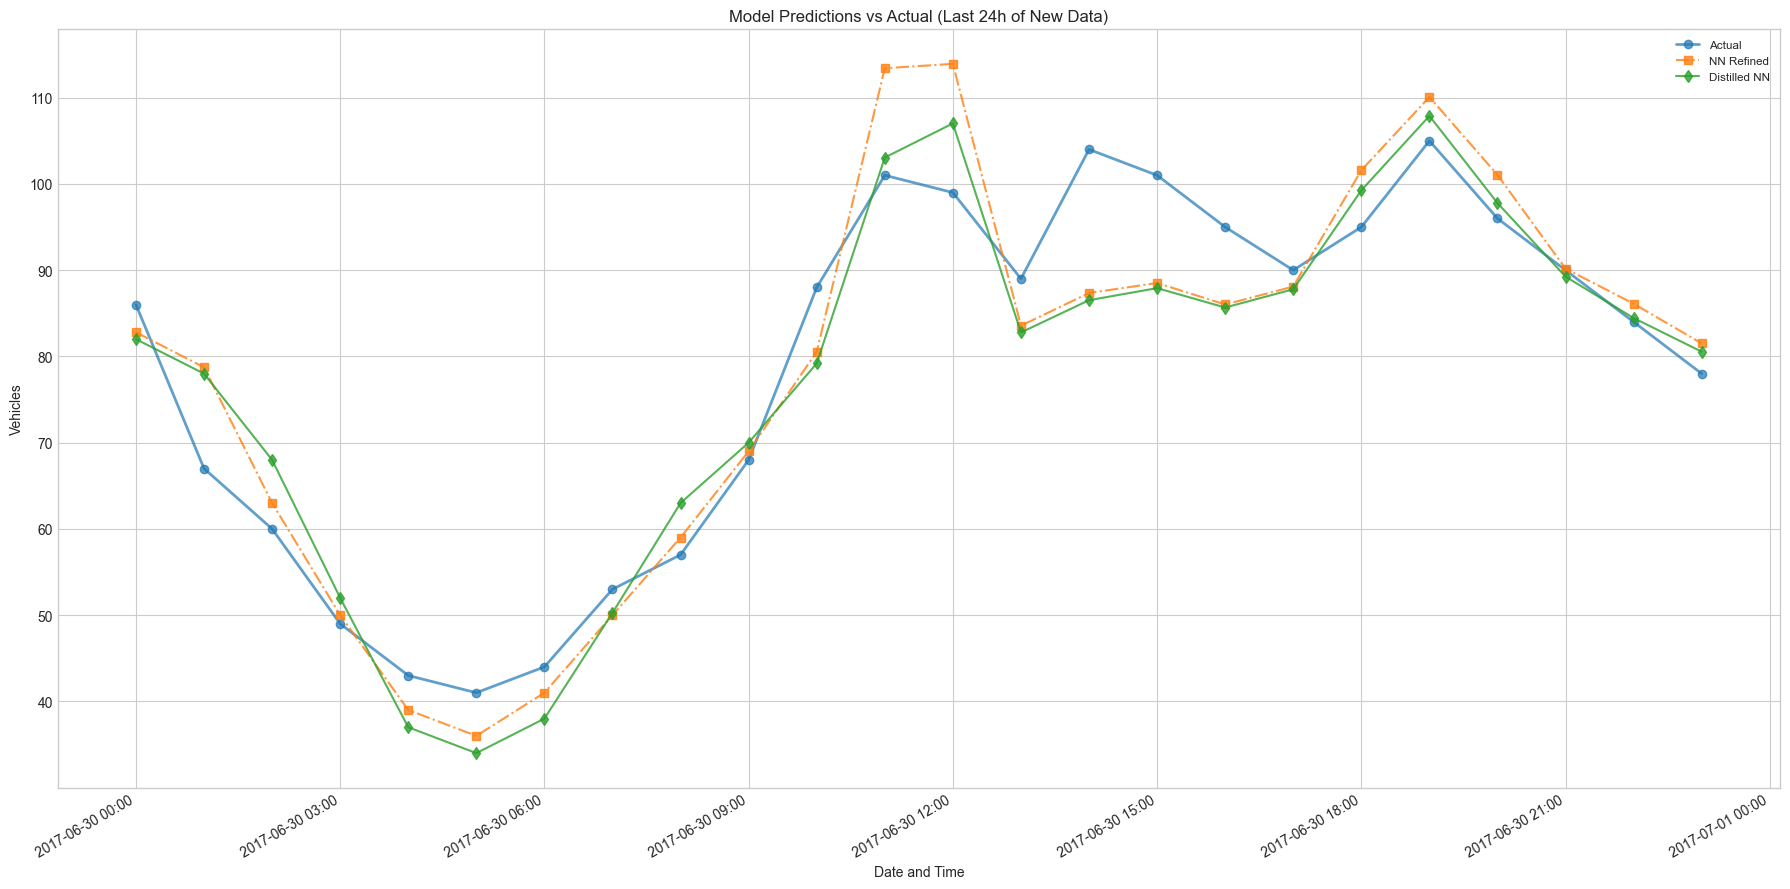


Prediction and visualization pipeline complete.


In [14]:
# Cell 13: Plotting and metrics
import pandas as pd # Added for DataFrame creation
import numpy as np # Added for np.nan, np.sqrt, etc.
import matplotlib.pyplot as plt # Added for plotting
import matplotlib.dates as mdates # Added for date formatting
import warnings # Added for warnings
# Ensure these are imported, typically in Cell 1 or an earlier setup cell:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import torch # For torch.cuda.is_available()

# --- Configuration for Evaluation (ensure EVAL_HORIZON is defined, e.g., in Cell 1) ---
if 'EVAL_HORIZON' not in globals():
    EVAL_HORIZON = 24
    print(f"EVAL_HORIZON not found in globals, setting to default: {EVAL_HORIZON}")

# --- Helper function to calculate metrics ---
def calculate_and_print_metrics(model_name, y_true, y_pred, period_label):
    # Ensure r2_score is available in the scope
    try:
        from sklearn.metrics import r2_score
    except ImportError:
        print("Warning: r2_score from sklearn.metrics could not be imported. R2 metric will be NaN.")
        # Define a dummy r2_score that returns NaN if not available
        def r2_score(y_true, y_pred): return np.nan

    if y_true is None or len(y_true) == 0:
        print(f"Actual values not available for {model_name} for {period_label}. Skipping metrics.")
        return np.nan, np.nan, np.nan # RMSE, MAE, R2
    if len(y_true) != len(y_pred):
        warnings.warn(f"Length mismatch for {model_name} ({period_label}): y_true ({len(y_true)}), y_pred ({len(y_pred)}). Skipping metrics.")
        return np.nan, np.nan, np.nan
    if np.isnan(y_pred).all():
        warnings.warn(f"All predictions for {model_name} ({period_label}) are NaN. Skipping metrics.")
        return np.nan, np.nan, np.nan

    valid_indices = ~np.isnan(y_pred) & ~np.isnan(y_true) # Ensure both true and pred are not NaN
    if not np.any(valid_indices):
        warnings.warn(f"No valid (non-NaN) predictions/actuals for {model_name} ({period_label}). Skipping metrics.")
        return np.nan, np.nan, np.nan
    
    y_true_valid = y_true[valid_indices]
    y_pred_valid = y_pred[valid_indices]

    if len(y_true_valid) == 0: # Should be caught by np.any(valid_indices) but as a safeguard
        warnings.warn(f"No overlapping valid data points for {model_name} ({period_label}). Skipping metrics.")
        return np.nan, np.nan, np.nan

    rmse = np.sqrt(mean_squared_error(y_true_valid, y_pred_valid))
    mae = mean_absolute_error(y_true_valid, y_pred_valid)
    r2 = r2_score(y_true_valid, y_pred_valid)
    print(f"{model_name} ({period_label}, {len(y_true_valid)} points) - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")
    return rmse, mae, r2

metrics_summary_last_n = {}
metrics_summary_full = {}

# Assuming y_actual_orig_aligned, patchtsmixer_preds_orig, xgb_final_preds_orig,
# nn_refine_final_preds_orig, distilled_nn_final_preds_orig,
# xgb_refine_model, nn_refine_model, distilled_nn_model,
# results_df, TARGET_COLUMN, DATETIME_COLUMN are defined in previous cells.

if 'y_actual_orig_aligned' in globals() and y_actual_orig_aligned is not None and len(y_actual_orig_aligned) > 0:
    print(f"\n--- Performance Metrics for Last {EVAL_HORIZON} Hours ---")
    num_available_predictions = len(y_actual_orig_aligned)
    eval_points_count_last_n = min(EVAL_HORIZON, num_available_predictions)

    if eval_points_count_last_n > 0:
        actuals_for_eval_last_n = y_actual_orig_aligned[-eval_points_count_last_n:]
        
        # Ensure all potential prediction variables exist or are None
        xgb_preds_to_use = xgb_final_preds_orig if 'xgb_refine_model' in globals() and xgb_refine_model is not None else None
        nn_preds_to_use = nn_refine_final_preds_orig if 'nn_refine_model' in globals() and nn_refine_model is not None else None
        distilled_preds_to_use = distilled_nn_final_preds_orig if 'distilled_nn_model' in globals() and distilled_nn_model is not None else None

        predictions_map = {
            "PatchTST": patchtst_preds_orig,
            "XGB_Refined": xgb_preds_to_use,
            "NN_Refined": nn_preds_to_use,
            "Distilled_NN": distilled_preds_to_use
        }

        for model_name, all_preds in predictions_map.items():
            if all_preds is not None and len(all_preds) == len(y_actual_orig_aligned): # Check length consistency
                preds_for_eval_last_n = all_preds[-eval_points_count_last_n:]
                rmse, mae, r2 = calculate_and_print_metrics(model_name, actuals_for_eval_last_n, preds_for_eval_last_n, f"Last {eval_points_count_last_n}h")
                if not (np.isnan(rmse) and np.isnan(mae) and np.isnan(r2)):
                    metrics_summary_last_n[model_name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
            elif all_preds is None:
                print(f"{model_name} not loaded or no predictions. Skipping metrics for Last {eval_points_count_last_n}h.")
            else: # Length mismatch
                 warnings.warn(f"Length mismatch for {model_name} (Last {eval_points_count_last_n}h eval): actuals ({len(actuals_for_eval_last_n)}), preds ({len(all_preds)}). Skipping.")


        if metrics_summary_last_n:
            metrics_df_last_n = pd.DataFrame.from_dict(metrics_summary_last_n, orient='index', columns=['RMSE', 'MAE', 'R2'])
            print(f"\n--- Metrics Summary (Last {eval_points_count_last_n}h) ---")
            print(metrics_df_last_n.sort_values(by='MAE')) # Or sort by 'R2' descending if preferred
        else:
            print(f"No models had valid predictions for metric calculation for the Last {eval_points_count_last_n}h.")
    else:
        print(f"Not enough predictions ({num_available_predictions}) to evaluate for the last {EVAL_HORIZON} hours.")

    print(f"\n--- Performance Metrics for Full Test Set ({len(y_actual_orig_aligned)} points) ---")
    actuals_for_eval_full = y_actual_orig_aligned

    for model_name, all_preds in predictions_map.items(): # predictions_map defined above
        if all_preds is not None:
            if len(all_preds) == len(actuals_for_eval_full):
                rmse, mae, r2 = calculate_and_print_metrics(model_name, actuals_for_eval_full, all_preds, "Full Test Set")
                if not (np.isnan(rmse) and np.isnan(mae) and np.isnan(r2)):
                    metrics_summary_full[model_name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
            else:
                warnings.warn(f"Length mismatch for {model_name} (Full Test Set): actuals ({len(actuals_for_eval_full)}), preds ({len(all_preds)}). Skipping full set metrics.")
        else:
            print(f"{model_name} not loaded or no predictions. Skipping metrics for Full Test Set.")

    if metrics_summary_full:
        metrics_df_full = pd.DataFrame.from_dict(metrics_summary_full, orient='index', columns=['RMSE', 'MAE', 'R2'])
        print("\n--- Metrics Summary (Full Test Set) ---")
        print(metrics_df_full.sort_values(by='MAE')) # Or sort by 'R2' descending
    else:
        print("No models had valid predictions for metric calculation for the Full Test Set.")
else:
    print(f"\nActual values (y_actual_orig_aligned) not available or empty. Skipping all metrics calculation.")

# --- Plotting (uses last EVAL_HORIZON or available for visualization clarity) ---
if 'results_df' in globals() and isinstance(results_df, pd.DataFrame) and not results_df.empty:
    print(f"\nPlotting predictions for the last {EVAL_HORIZON}h (or available)...")
    num_plot_points = min(EVAL_HORIZON, len(results_df))
    plot_df = results_df.iloc[-num_plot_points:]

    plt.figure(figsize=(18, 9))

    actual_col_name = 'Actual_' + TARGET_COLUMN
    if actual_col_name in plot_df.columns and not plot_df[actual_col_name].isnull().all():
        plt.plot(plot_df[DATETIME_COLUMN], plot_df[actual_col_name], label='Actual', marker='o', linestyle='-', alpha=0.7, linewidth=2)

    model_plot_info = [
        ('PatchTSMixer_Pred', 'PatchTSMixer', '^', ':'),
        ('XGB_Refined_Pred', 'XGB Refined', 'x', '--'),
        ('NN_Refined_Pred', 'NN Refined', 's', '-.'),
        ('Distilled_NN_Pred', 'Distilled NN', 'd', '-')
    ]

    for col_name, label_name, marker_style, line_style in model_plot_info:
        if col_name in plot_df.columns and not plot_df[col_name].isnull().all():
            mae_val_legend = metrics_summary_last_n.get(label_name, {}).get('MAE', np.nan)
            rmse_val_legend = metrics_summary_last_n.get(label_name, {}).get('RMSE', np.nan)
            r2_val_legend = metrics_summary_last_n.get(label_name, {}).get('R2', np.nan)
            
            plot_label_text = f'{label_name}'
            metrics_texts = []
            if not np.isnan(mae_val_legend): metrics_texts.append(f'MAE: {mae_val_legend:.2f}')
            if not np.isnan(rmse_val_legend): metrics_texts.append(f'RMSE: {rmse_val_legend:.2f}')
            if not np.isnan(r2_val_legend): metrics_texts.append(f'R2: {r2_val_legend:.2f}')
            
            if metrics_texts:
                 plot_label_text += f' (Last {num_plot_points}h: {", ".join(metrics_texts)})'
            
            plt.plot(plot_df[DATETIME_COLUMN], plot_df[col_name], label=plot_label_text, marker=marker_style, linestyle=line_style, alpha=0.8)

    plt.title(f'Model Predictions vs Actual (Last {num_plot_points}h of New Data)')
    plt.xlabel('Date and Time')
    plt.ylabel(TARGET_COLUMN)
    plt.legend(loc='best', fontsize='small')
    plt.grid(True)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=max(1, num_plot_points//6), maxticks=12)) # Dynamic ticks
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()

    if not (actual_col_name in plot_df.columns and not plot_df[actual_col_name].isnull().all()):
        print("\nNote: Actual values were not plotted as they are not available or all NaN in the plotted segment.")
else:
    print("\nSkipping plotting as 'results_df' is not available, not a DataFrame, or is empty.")


print("\nPrediction and visualization pipeline complete.")
if 'torch' in globals() and torch.cuda.is_available():
    torch.cuda.empty_cache()